Loading data...

==== Weekend vs Weekday Price Analysis ====
Number of weekend observations: 589212
Number of weekday observations: 815257

Weekend mean price: 214.97
Weekday mean price: 201.95
Difference: 13.01 (6.44%)

Weekend median price: 155.33
Weekday median price: 152.00
Difference: 3.33 (2.19%)

T-test statistic: 42.1481
P-value: 0.00000000
Result: Weekend prices are significantly different from weekday prices (p < 0.05)


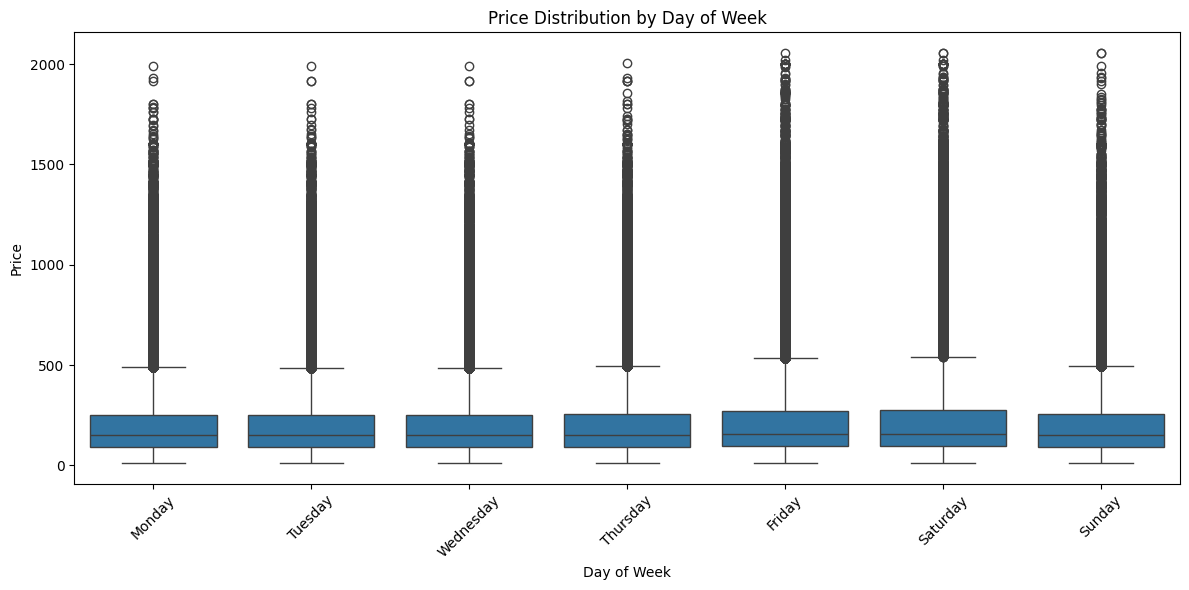

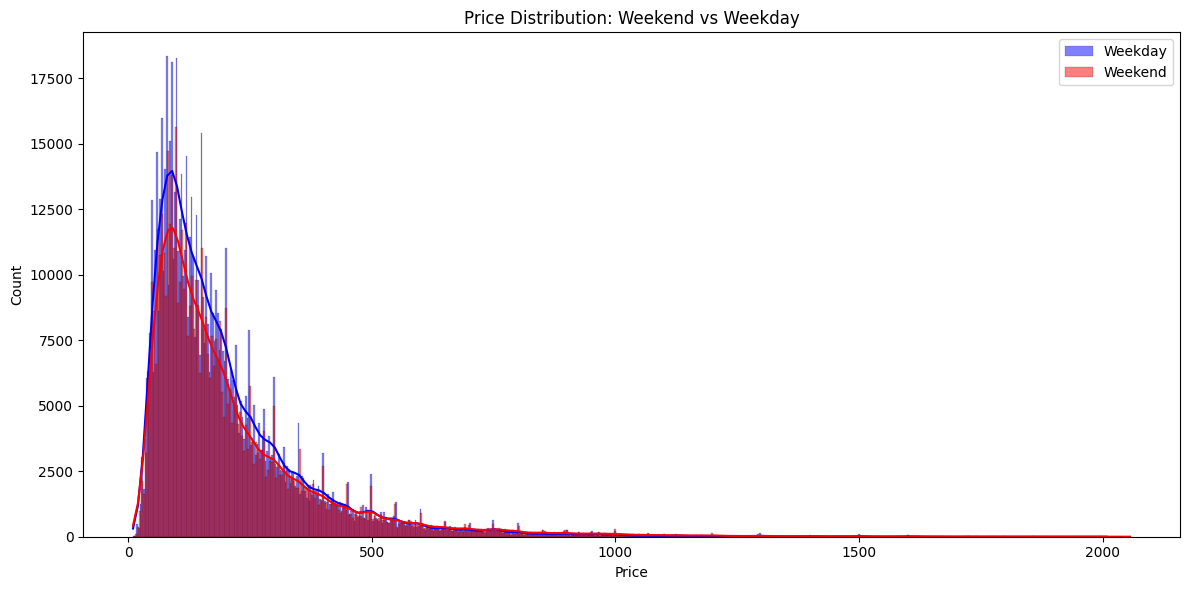

KeyError: "None of [Index([0, 0, 0, 0, 1, 1, 1, 0, 0, 0,\n       ...\n       0, 0, 0, 1, 1, 1, 0, 0, 0, 0],\n      dtype='int64', length=186)] are in the [columns]"

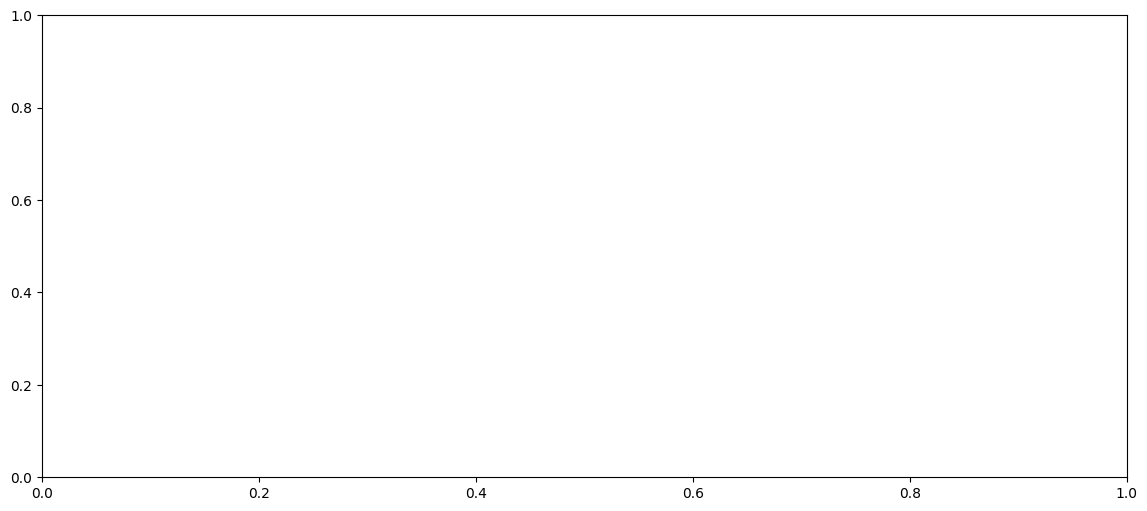

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm

def analyze_weekend_price_effect(train_path, plot=True):
    """
    Analyze whether prices are higher on weekends compared to weekdays.
    
    Parameters:
    -----------
    train_path : str
        Path to the training data CSV file
    plot : bool, optional
        Whether to create and show plots
        
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    print("Loading data...")
    data = pd.read_csv(train_path)
    
    # Convert date to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Create weekend indicator if it doesn't exist
    if 'DTF_is_weekend' not in data.columns:
        data['DTF_is_weekend'] = data['date'].dt.dayofweek >= 5  # 5 = Saturday, 6 = Sunday
    
    # Group data by weekend/weekday
    weekend_data = data[data['DTF_is_weekend'] == True]
    weekday_data = data[data['DTF_is_weekend'] == False]
    
    # Calculate basic statistics
    weekend_mean = weekend_data['price'].mean()
    weekday_mean = weekday_data['price'].mean()
    weekend_median = weekend_data['price'].median()
    weekday_median = weekday_data['price'].median()
    
    # Calculate percentage difference
    pct_diff_mean = ((weekend_mean / weekday_mean) - 1) * 100
    pct_diff_median = ((weekend_median / weekday_median) - 1) * 100
    
    # Run t-test to check if difference is statistically significant
    t_stat, p_value = ttest_ind(weekend_data['price'].values, weekday_data['price'].values, equal_var=False)
    
    # Print results
    print("\n==== Weekend vs Weekday Price Analysis ====")
    print(f"Number of weekend observations: {len(weekend_data)}")
    print(f"Number of weekday observations: {len(weekday_data)}")
    print(f"\nWeekend mean price: {weekend_mean:.2f}")
    print(f"Weekday mean price: {weekday_mean:.2f}")
    print(f"Difference: {weekend_mean - weekday_mean:.2f} ({pct_diff_mean:.2f}%)")
    print(f"\nWeekend median price: {weekend_median:.2f}")
    print(f"Weekday median price: {weekday_median:.2f}")
    print(f"Difference: {weekend_median - weekday_median:.2f} ({pct_diff_median:.2f}%)")
    print(f"\nT-test statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.8f}")
    if p_value < 0.05:
        print("Result: Weekend prices are significantly different from weekday prices (p < 0.05)")
    else:
        print("Result: No significant difference between weekend and weekday prices (p >= 0.05)")
    
    # Create plots if requested
    if plot:
        # Plot 1: Box plot of prices by day of week
        plt.figure(figsize=(12, 6))
        data['day_of_week'] = data['date'].dt.dayofweek
        data['day_name'] = data['date'].dt.day_name()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        
        sns.boxplot(x='day_name', y='price', data=data, order=day_order)
        plt.title('Price Distribution by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Plot 2: Price distribution weekend vs weekday
        plt.figure(figsize=(12, 6))
        sns.histplot(weekday_data['price'], color='blue', alpha=0.5, label='Weekday', kde=True)
        sns.histplot(weekend_data['price'], color='red', alpha=0.5, label='Weekend', kde=True)
        plt.title('Price Distribution: Weekend vs Weekday')
        plt.xlabel('Price')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Plot 3: Daily average price over time with weekend highlighting
        daily_avg = data.groupby([data['date'].dt.date, data['DTF_is_weekend']])['price'].mean().reset_index()
        daily_avg.columns = ['date', 'is_weekend', 'avg_price']
        
        plt.figure(figsize=(14, 6))
        ax = plt.axes()
        
        # Highlight weekend areas
        weekend_dates = daily_avg[daily_avg['is_weekend']]['date'].unique()
        for date in weekend_dates:
            ax.axvspan(date, pd.to_datetime(date) + pd.Timedelta(days=1), alpha=0.2, color='red')
        
        # Plot daily average price
        sns.lineplot(x='date', y='avg_price', data=daily_avg, markers=True, ax=ax)
        plt.title('Daily Average Price Over Time (Red Highlights: Weekends)')
        plt.xlabel('Date')
        plt.ylabel('Average Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Plot 4: Average price by day of week with confidence intervals
        day_stats = data.groupby('day_name')['price'].agg(['mean', 'count', 'std']).reset_index()
        day_stats = day_stats.reindex(pd.Categorical(day_stats['day_name'], categories=day_order, ordered=True).argsort())
        day_stats['ci'] = 1.96 * day_stats['std'] / np.sqrt(day_stats['count'])
        
        plt.figure(figsize=(12, 6))
        plt.errorbar(day_stats['day_name'], day_stats['mean'], yerr=day_stats['ci'], fmt='o', capsize=5)
        plt.title('Average Price by Day of Week with 95% Confidence Intervals')
        plt.xlabel('Day of Week')
        plt.ylabel('Average Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Plot 5: Regression analysis controlling for listing effects
        # Create dummy variables for days of week
        data['day_of_week'] = data['date'].dt.dayofweek
        day_dummies = pd.get_dummies(data['day_of_week'], prefix='day', drop_first=True)
        
        # Add listing fixed effects
        listing_dummies = pd.get_dummies(data['listing_id'], prefix='listing', drop_first=True)
        
        # Combine for regression
        X = pd.concat([day_dummies, listing_dummies], axis=1)
        X = sm.add_constant(X)
        y = data['price']
        
        try:
            # Run regression
            model = sm.OLS(y, X).fit()
            print("\n==== Regression Analysis (controlling for listing fixed effects) ====")
            day_coeffs = {f"day_{i}": model.params[f"day_{i}"] for i in range(1, 7)}
            print("Day coefficients (relative to Monday):")
            for day, coef in day_coeffs.items():
                day_num = int(day.split('_')[1])
                day_name = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][day_num-1]
                print(f"{day_name}: {coef:.4f} (p-value: {model.pvalues[day]:.4f})")
                
            # Plot day coefficients
            days = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            coeffs = list(day_coeffs.values())
            pvals = [model.pvalues[f"day_{i}"] for i in range(1, 7)]
            
            plt.figure(figsize=(10, 6))
            bars = plt.bar(days, coeffs)
            
            # Color bars by statistical significance
            for i, p in enumerate(pvals):
                if p < 0.05:
                    bars[i].set_color('red')
                else:
                    bars[i].set_color('blue')
                    
            plt.title('Day of Week Effect on Price (Controlling for Listing Fixed Effects)')
            plt.xlabel('Day of Week (Relative to Monday)')
            plt.ylabel('Price Effect')
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Regression analysis could not be completed: {e}")
            
    # Return results
    return {
        'weekend_mean': weekend_mean,
        'weekday_mean': weekday_mean,
        'weekend_median': weekend_median,
        'weekday_median': weekday_median,
        'pct_diff_mean': pct_diff_mean,
        'pct_diff_median': pct_diff_median,
        't_stat': t_stat,
        'p_value': p_value
    }

# Example usage
if __name__ == "__main__":
    train_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_up3.csv" 
    results = analyze_weekend_price_effect(train_path)